In [80]:
import bagpy
from bagpy import bagreader
from datetime import datetime
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import os

In [12]:
PID = '1_EXP05_Full/'
week = 'week_1/'
rosbag = 'rosbag_common_2017-07-14-12-53-49_0.bag'
b = bagreader(PID + rosbag)

[INFO]  Data folder 1_EXP05_Full/rosbag_common_2017-07-14-12-53-49_0 already exists. Not creating.


In [25]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def get_timestamp(file):
    start_year = find_nth(file, '_', 2) + 1
    start_month = find_nth(file, '-', 1) + 1
    start_day = find_nth(file, '-', 2) + 1
    start_hour = find_nth(file, '-', 3) + 1
    start_minute = find_nth(file, '-', 4) + 1
    start_second = find_nth(file, '-', 5) + 1
    
    end_year = find_nth(file, '-', 1)
    end_month = find_nth(file, '-', 2)
    end_day = find_nth(file, '-', 3)
    end_hour = find_nth(file, '-', 4)
    end_minute = find_nth(file, '-', 5)
    end_second = find_nth(file, '_', 3)
    
    year = file[start_year:end_year]
    month = file[start_month:end_month]
    day = file[start_day:end_day]
    hour = file[start_hour:end_hour]
    minute = file[start_minute:end_minute]
    second = file[start_second:end_second]
    
    return year, month, day, hour, minute, second

# y, mo, d, h, mi, s = get_timestamp(rosbag)

In [81]:
def unix_to_datetime(ts):
    return datetime.utcfromtimestamp(ts)

In [37]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/rosout,rosgraph_msgs/Log,764,3566.585034
1,/sar/game_command,sar_game_command_msgs/GameCommand,3,0.006492
2,/sar/game_state,sar_game_command_msgs/GameState,9,0.387295
3,/sar/jibo/animation,sar_jibo_command_msgs/JiboAnimation,59,0.221483
4,/sar/jibo/health,sar_jibo_command_msgs/JiboHealth,9,0.016653
5,/sar/jibo/lookat,sar_jibo_command_msgs/JiboLookat,5,0.048415
6,/sar/jibo/robot_attention_target,std_msgs/String,5581,10.000272
7,/sar/jibo/speech,sar_jibo_command_msgs/JiboSpeech,71,0.227206
8,/sar/jibo/state,sar_robot_command_msgs/RobotState,10850,19.933294
9,/sar/jibo/verbose_state,std_msgs/String,902,1.803065


In [38]:
csvfiles = []
for t in b.topics:
    data = b.message_by_topic(t)
    csvfiles.append(data)

In [38]:
def read_bags(source):
    bags = [f for f in os.listdir(source) if f.endswith('.bag')]

    df_attention = None
    df_robotgaze = None

    for bag in bags:
        b = bagreader(source + bag)

        b_attention = b.message_by_topic('/sar/perception/attention_targets')
        b_robotgaze = b.message_by_topic('/sar/jibo/robot_attention_target')

        temp_attention = pd.read_csv(b_attention)
        temp_robotgaze = pd.read_csv(b_robotgaze)

        df_attention = pd.concat([df_attention, temp_attention], ignore_index=True)
        df_robotgaze = pd.concat([df_robotgaze, temp_robotgaze], ignore_index=True)
    
    return df_attention, df_robotgaze

In [39]:
df_attention_w1, df_robotgaze_w1 = read_bags(PID + 'week_1/')

[INFO]  Data folder 1_EXP05_Full/week_1/rosbag_common_2017-07-07-16-03-16_0 already exists. Not creating.
[INFO]  Data folder 1_EXP05_Full/week_1/rosbag_common_2017-07-10-14-35-39_0 already exists. Not creating.
[INFO]  Data folder 1_EXP05_Full/week_1/rosbag_common_2017-07-10-14-45-39_1 already exists. Not creating.
[INFO]  Data folder 1_EXP05_Full/week_1/rosbag_common_2017-07-10-14-55-39_2 already exists. Not creating.
[INFO]  Data folder 1_EXP05_Full/week_1/rosbag_common_2017-07-11-16-03-57_0 already exists. Not creating.
[INFO]  Data folder 1_EXP05_Full/week_1/rosbag_common_2017-07-14-12-53-49_0 already exists. Not creating.


## Gaze Tracking

In [21]:
def get_region(role, attention_string):
    attention = re.sub(r'\W+', '', attention_string)
    start_region = find_nth(attention, role, 1) + len(role) + len('region')
    end_region = find_nth(attention[start_region:], 'role', 1) + start_region
    end_region = len(attention) if (end_region == -1 or end_region < start_region) else end_region
    region = attention[start_region:end_region]
    return region

In [22]:
def get_human_attention(df, role):

    prev_object = get_region(role, df['attention'].at[0])
    prev_timestamp = float(df['Time'].at[0])
    duration = 0
    start_index = 0

    role_attention = []
    role_timestamp = []
    role_duration = []

    for index, row in df.iterrows():
        curr_object = get_region(role, row['attention'])

        # same attentional object
        if curr_object == prev_object:
            duration = duration + (float(row['Time']) - prev_timestamp)
            prev_timestamp = float(row['Time'])

        # detected change in attentional object
        else:
            # record the object and duration
            role_attention.append(prev_object)
            role_duration.append(duration)
            role_timestamp.append(df['Time'].at[start_index])

            # reset pointers
            prev_object = curr_object
            prev_timestamp = float(row['Time'])

            # reset duration for new object
            duration = 0
            start_index = index

            # print(role_attention[-1], role_duration[-1], role_timestamp[-1])
    
    return role_attention, role_timestamp, role_duration

In [23]:
def get_robot_attention(df):

    prev_object = df['data'].at[0]
    prev_timestamp = float(df['Time'].at[0])
    duration = 0
    start_index = 0

    role_attention = []
    role_timestamp = []
    role_duration = []

    for index, row in df.iterrows():
        curr_object = row['data']

        # same attentional object
        if curr_object == prev_object:
            duration = duration + (float(row['Time']) - prev_timestamp)
            prev_timestamp = float(row['Time'])

        # detected change in attentional object
        else:
            # record the object and duration
            role_attention.append(prev_object)
            role_duration.append(duration)
            role_timestamp.append(df['Time'].at[start_index])

            # reset pointers
            prev_object = curr_object
            prev_timestamp = float(row['Time'])

            # reset duration for new object
            duration = 0
            start_index = index

            # print(role_attention[-1], role_duration[-1], role_timestamp[-1])
    
    return role_attention, role_timestamp, role_duration

In [40]:
def attention_csvs(source, df_attention, df_robotgaze):
    c_objects, c_timestamps, c_durations = get_human_attention(df_attention, 'child')
    p_objects, p_timestamps, p_durations = get_human_attention(df_attention, 'parent')
    r_objects, r_timestamps, r_durations = get_robot_attention(df_robotgaze)
    
    child = pd.DataFrame({'object': c_objects, 'duration': c_durations, 'start': c_timestamps})
    parent = pd.DataFrame({'object': p_objects, 'duration': p_durations, 'start': p_timestamps})
    robot = pd.DataFrame({'object': r_objects, 'duration': r_durations, 'start': r_timestamps})
    
    child.to_csv(source + 'child.csv')
    parent.to_csv(source + 'parent.csv')
    robot.to_csv(source + 'robot.csv')
    
    return child, parent, robot

In [43]:
df_c, df_p, df_r = attention_csvs(PID + 'week_1/', df_attention_w1, df_robotgaze_w1)

## Joint Attention

In [44]:
def get_overlap(df1, df2, self):
    
    df1.name = self[0]
    df2.name = self[1]
    
    # determine the object with the more frequent changes in gaze
    primary = None
    secondary = None
    if len(df1) > len(df2):
        primary = df1
        secondary = df2
    else:
        primary = df2
        secondary = df1
        
    joint_object = []
    joint_duration = []
    joint_timestamp = []
    joint_initiator = [] # who looked first?
    joint_lag = [] # response lag
    
    for index_p, row_p in primary.iterrows():
        for index_s, row_s in secondary.iterrows():
            if (
                (row_s['object'] == row_p['object']) or # looking at the same object
                (row_s['object'] in self) or # object 1 is looking at object 2
                (row_p['object'] in self) # object 2 is looking at object 1
            ) and ( # timestamps overlap
                float(row_s['start']) <= float(row_p['start']) <= (float(row_s['start']) + float(row_s['duration']))
            ):
                start = max([float(row_p['start']), float(row_s['start'])])
                duration = min([float(row_p['duration']), float(row_s['duration'])])
                initiator = secondary.name if row_s['start'] == min([float(row_p['start']), float(row_s['start'])]) else primary.name
                
                joint_object.append('contact' if row_s['object'] in self else row_s['object'])
                joint_timestamp.append(start)
                joint_duration.append(duration)
                joint_initiator.append(initiator)
                joint_lag.append(start - min([float(row_p['start']), float(row_s['start'])]))
                
                # print(joint_object[-1], joint_duration[-1], joint_timestamp[-1], joint_initiator[-1], joint_lag[-1])
                break

    return joint_object, joint_timestamp, joint_duration, joint_initiator, joint_lag

In [185]:
def joint_attention_csvs(source, child, parent, robot):
    cr_objects, cr_timestamps, cr_durations, cr_initiator, cr_lag = get_overlap(child, robot, ['child', 'robot'])
    cp_objects, cp_timestamps, cp_durations, cp_initiator, cp_lag = get_overlap(child, parent, ['child', 'parent'])
    pr_objects, pr_timestamps, pr_durations, pr_initiator, pr_lag = get_overlap(parent, robot, ['parent', 'robot'])
    
    child_robot = pd.DataFrame({'object': cr_objects, 'duration': cr_durations, 'start': cr_timestamps, 'initiator': cr_initiator, 'lag': cr_lag})
    child_parent = pd.DataFrame({'object': cp_objects, 'duration': cp_durations, 'start': cp_timestamps, 'initiator': cp_initiator, 'lag': cp_lag})
    parent_robot = pd.DataFrame({'object': pr_objects, 'duration': pr_durations, 'start': pr_timestamps, 'initiator': pr_initiator, 'lag': pr_lag})

    child_robot.to_csv(source + 'child-robot.csv', index=False)
    child_parent.to_csv(source + 'child-parent.csv', index=False)
    parent_robot.to_csv(source + 'parent-robot.csv', index=False)
    
    return child_robot, child_parent, parent_robot

In [ ]:
df_cr, df_cp, df_pr = joint_attention_csvs(PID + 'week_1/', df_c, df_p, df_r)

In [184]:
# read from existing files
df_cr = pd.read_csv(PID + 'week_1/' + 'child-robot.csv')
df_cp = pd.read_csv(PID + 'week_1/' + 'child-parent.csv')
df_pr = pd.read_csv(PID + 'week_1/' + 'parent-robot.csv')

TypeError: read_csv() got an unexpected keyword argument 'index'

## Visual Analysis

In [116]:
plt.rcParams.update(plt.rcParamsDefault)

In [182]:
# remove outliers
df_cr = df_cr[(np.abs(stats.zscore(df_cr['lag'])) < 3)]
df_cp = df_cp[(np.abs(stats.zscore(df_cp['lag'])) < 3)]
df_pr = df_pr[(np.abs(stats.zscore(df_pr['lag'])) < 3)]

In [183]:
df_cr

,Unnamed: 0,object,duration,start,initiator,lag
0,0,contact,0.999396,1.499458e+09,robot,13.697562
1,1,contact,19.099964,1.499458e+09,robot,14.796889
2,2,contact,1.499971,1.499458e+09,robot,0.904794
3,3,contact,2.199933,1.499458e+09,robot,2.504795
4,4,contact,0.199958,1.499458e+09,robot,4.804777
...,...,...,...,...,...,...
1106,1106,screen,0.100012,1.500052e+09,robot,9.743358
1107,1107,screen,0.700130,1.500052e+09,robot,12.343449
1108,1108,screen,1.900110,1.500052e+09,robot,13.143455
1109,1109,screen,0.200094,1.500052e+09,robot,15.143565


In [177]:
def get_unique_days(df_column):
    realtime = df_column.apply(lambda x: unix_to_datetime(x))
    days = np.array(realtime.apply(lambda x: x.day))
    return days, np.unique(days)

In [178]:
days, unique_days = get_unique_days(df_cr['start'])

In [156]:
df_cr.insert(0, 'datetime', df_cr['start'].apply(lambda x: unix_to_datetime(x).day))

In [173]:
dfs_days = []
for day in unique_days:
    df_day = df_cr[df_cr['datetime']==day]
    df_day = df_day.drop('datetime', axis=1)
    dfs_days.append(df_day)

In [174]:
dfs_days[0]

,Unnamed: 0,object,duration,start,initiator,lag
0,0,contact,0.999396,1.499458e+09,robot,13.697562
1,1,contact,19.099964,1.499458e+09,robot,14.796889
2,2,contact,1.499971,1.499458e+09,robot,0.904794
3,3,contact,2.199933,1.499458e+09,robot,2.504795
4,4,contact,0.199958,1.499458e+09,robot,4.804777
5,5,contact,10.499978,1.499458e+09,robot,5.104743
6,6,contact,0.700266,1.499458e+09,robot,15.704830
7,7,contact,16.600115,1.499458e+09,robot,16.504806
8,8,contact,2.599977,1.499458e+09,robot,33.204846
9,9,contact,4.600059,1.499458e+09,robot,35.904797


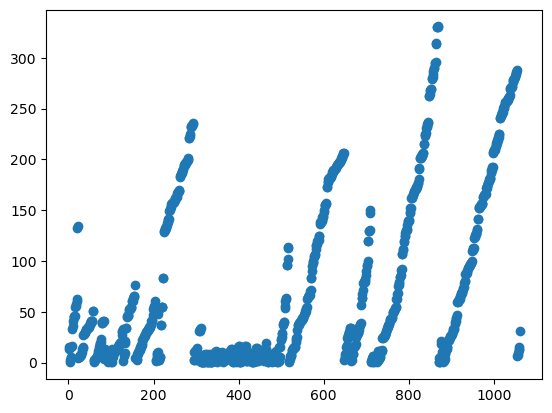

In [117]:
# plt.scatter(df_cr['start'] - df_cr['start'].at[0], df_cr['lag'])
plt.scatter(list(range(1, len(df_cr['start']) + 1)), df_cr['lag'])